# 1. Introdução
------
Este notebook tem por objetivo demonstrar alguns casos de base em matrizes maiores. Para verificar os casos de base com matrizes fundamentais, veja o notebook [aqui](https://github.com/rsautter/GPA/tree/master/Examples/FundamentalMatrix.ipynb).

Neste notebook é apresentado a função de [densidade de probabilidade da distribuição normal](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_normal) e a função de [Bessel](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_de_Bessel) para os casos de padrões simétricos. Também é apresentado os [ruídos coloridos](http://adsabs.harvard.edu/pdf/1995A%26A...300..707T) e o [ruído de Perlin](https://en.wikipedia.org/wiki/Perlin_noise).



Rode a célula a seguir, caso esteja utilizando o colab. As células a seguir instalam as bibliotecas GPA, ruído colorido e ruído de Perlin. 

In [ ]:
!pip install git+https://github.com/rsautter/GPA

In [1]:
!pip install git+https://github.com/felixpatzelt/colorednoise

  Cloning https://github.com/felixpatzelt/colorednoise to c:\users\ruben\appdata\local\temp\pip-req-build-9w3l5yq3
  Created wheel for colorednoise: filename=colorednoise-1.1.1-py3-none-any.whl size=3991 sha256=f687e1ac07cd15a11477f71b1741088aa60846b9ceb03ecd2016827c10cc07f3
  Stored in directory: C:\Users\ruben\AppData\Local\Temp\pip-ephem-wheel-cache-c9cz6h_o\wheels\bc\a5\09\c9221fcb4fe402b0b472b40622a358679759b5ea265b61a819
Successfully built colorednoise


  Running command git clone -q https://github.com/felixpatzelt/colorednoise 'C:\Users\ruben\AppData\Local\Temp\pip-req-build-9w3l5yq3'


In [44]:
!pip install perlin-noise

  Created wheel for perlin-noise: filename=perlin_noise-1.7-py3-none-any.whl size=3765 sha256=793724cb4a203cc321e50920934091a5546f0bc5c1bad60121d4fca9624a01ce
  Stored in directory: c:\users\ruben\appdata\local\pip\cache\wheels\c1\d6\94\191eaf27eb8ef542daf5abb9f8151a8a96e9daa4849bdd10d0
Successfully built perlin-noise


A célula a seguir invoca as bibliotecas de manipulação de vetores, geradora de casos base da física e estatística, plotagem e o próprio GPA 

In [1]:
import GPA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches
import tqdm as tqdm

# bibliotecas que geram funcoes
import scipy.stats as stats
import scipy.special as special

# bibliotecas de ruidos
import colorednoise as cn
from perlin_noise import PerlinNoise

### Criando um objeto

In [4]:
ga = GPA.GPA(0.04)

### Plot com classificação

In [3]:
def plotGPAVecClass(mat,ga,vectorsperDimension=10):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    im = plt.imshow(mat,origin='lower',alpha=0.65,cmap = 'jet',extent=[0,len(mat),0,len(mat)])
    plt.colorbar(im,shrink=0.9)
    #meshgrid = np.meshgrid(np.arange(0,len(mat))+.5,np.arange(0,len(mat))+.5)
    #plt.quiver(meshgrid[0],meshgrid[1],ga.gradient_dx,ga.gradient_dy)
    plt.title("Amplitude and Gradient Field")
    
    plt.subplot(1,2,2)
    classificationMap = np.array(ga.unknownP) + 3*np.array(ga.asymmetricalP) + 5*np.array(ga.symmetricalP) 
    cmap = colors.ListedColormap(['white','red','blue'])
    norm = colors.BoundaryNorm([0,2,5,6], cmap.N)
    plt.imshow(classificationMap,origin='lower',cmap=cmap,extent=[0,len(mat),0,len(mat)],alpha=0.65,norm=norm, interpolation='none')
    legendColors = [mpatches.Patch(facecolor='white', label='Unknown', edgecolor='k'),
                    mpatches.Patch(facecolor='red', label='Asymmetrical', edgecolor='k'),
                    mpatches.Patch(facecolor='blue', label='Symmetrical', edgecolor='k')]
    plt.legend(handles=legendColors, bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.title("Vector Class")
    plt.show()

# 2. Gauss
-----

Um exemplo notório de matriz para estudo de padrões é a distribuição de densidade de probabilidade da distribuição (PDF) normal. A função é dada por:

$$ f(x) = {1 \over \sigma \sqrt{2\pi}} e^{-{1\over 2} \left({x-\mu \over \sigma}\right)^2}$$

Nesta função $\mu$ é a média, que determina a localização do máximo da função, e $\sigma$ é o desvio padrão. Para a implementação da [signal.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html), o parâmetro $\mu$ é chamado loc e $\sigma$ é chamado scale.  


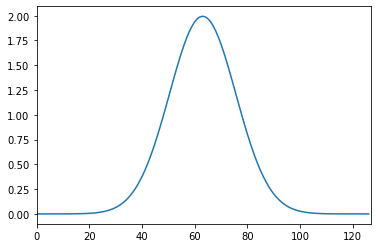

In [5]:
x = np.linspace(-1,1,127)
gauss1D = stats.norm(loc=0.0,scale=0.2).pdf(x)
plt.figure()
plt.plot(gauss1D)
plt.xlim(0,len(gauss1D))
plt.show()

Para gerar a matriz que corresponde a distribuição PDF normal, precisamos primeiramente mapear em cada elemento da matriz  a distância correspondente, para então aplicar a função. A matriz de distâncias foi calculada utilizado a função [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html), em combinação à funções vetoriais que calculam a distância euclidiana.

Uma alternativa seria gerar uma PDF normal unidimensional e aplicar o produto externo para gerar uma matriz de PDF normal. 

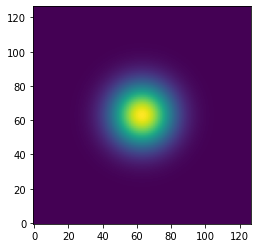

In [6]:
x = np.linspace(-1.0,1.0,127)
dx,dy = np.meshgrid(x,x)
x2D = np.sqrt(dx**2+dy**2)

gauss2D = stats.norm(loc=0.0,scale=0.2).pdf(x2D)

plt.figure()
plt.imshow(gauss2D,origin='lower')
plt.show()

A célula a seguir aplica o algoritmo de GPA nos três primeiros momentos, tanto para a parte simétrica quanto para a parte assimétrica do padrão. 

O valor para a medida relacionada a assimetria deve ser nula, uma vez que não há vetores assimétricos. Enquanto o primeiro e segundo momento da parte simétrica devem tender a 2, por se tratar de um campo gradiente com padrão regular e alta variabilidade de módulo. O terceiro momento do campo gradiente para a parte simétrica é no entanto a constante 1, pois os vetores estão alinhados  para o centro da matriz.

In [7]:
moments = ga.evaluate(gauss2D, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(gauss2D, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [0. 0. 0.]
Momentos do campo gradiente simétrico: [1.991 1.925 1.   ]


A célula a seguir mostra alguns vetores e a classificação do campo vetorial. O ponto central da matriz e a parte externa possuem módulo próximo a zero, dificultando assim a determinação a direção. Sendo assim, esses vetores foram classificados como indeterminados. 

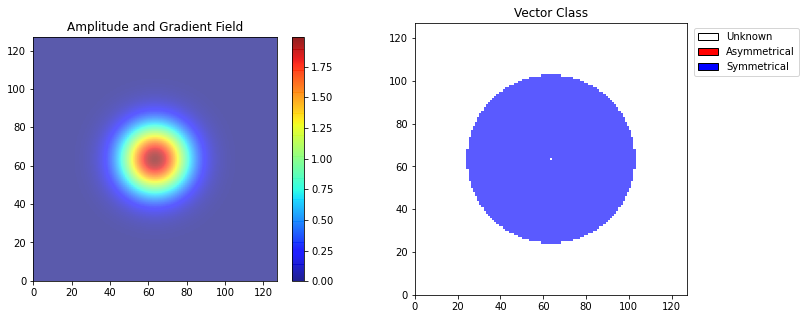

In [8]:
plotGPAVecClass(gauss2D,ga)

# 3. Bessel
-----

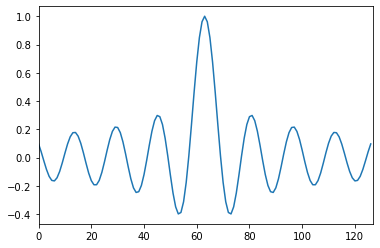

In [9]:
x = np.linspace(-25.0,25.0,127)
besselJ01D = special.j0(x)
plt.figure()
plt.plot(besselJ01D)
plt.xlim(0,len(besselJ01D))
plt.show()

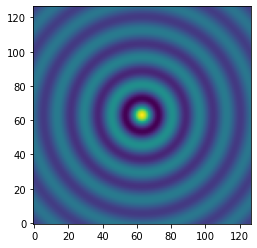

In [10]:
x = np.linspace(-25.0,25.0,127)
dx,dy = np.meshgrid(x,x)
x2D = np.sqrt(dx**2+dy**2)

besselJ02D = special.j0(x2D)

plt.figure()
plt.imshow(besselJ02D,origin='lower')
plt.show()

A célula a seguir aplica o algoritmo de GPA nos três primeiros momentos, tanto para a parte simétrica quanto para a parte assimétrica do padrão. 

O valor para a medida relacionada a assimetria deve ser nula, uma vez que não há vetores assimétricos. Enquanto o primeiro e segundo momento da parte simétrica devem tender a 2, por se tratar de um campo gradiente com padrão com vetores espalhados regularmente e que possuem alta variabilidade de módulo. O terceiro momento do campo gradiente para a parte simétrica é no entanto tende a constante 1.5, pois todos vetores estão alinhados o centro da matriz. Diferentemente da PDF normal, os vetores variam de sentido, metade dos vetores simétricos apontam para o centro da matriz e a outra metade aponta para a parte externa da matriz. Sendo assim, a medida é similar ao rotacional do campo gradiente.

In [11]:
moments = ga.evaluate(besselJ02D, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,5))

moments = ga.evaluate(besselJ02D, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,5))

Momentos do campo gradiente assimétrico: [0. 0. 0.]
Momentos do campo gradiente simétrico: [1.997   1.97205 1.51408]


Novamente o ponto central do padrão possui um vetor indeterminados quanto à simetria, devido a incapacidade de determinar a direção do vetor.

Diferentemente da PDF normal, a função de Bessel possui outros pontos críticos, vales e cristas possuem também derivada próxima a zero.

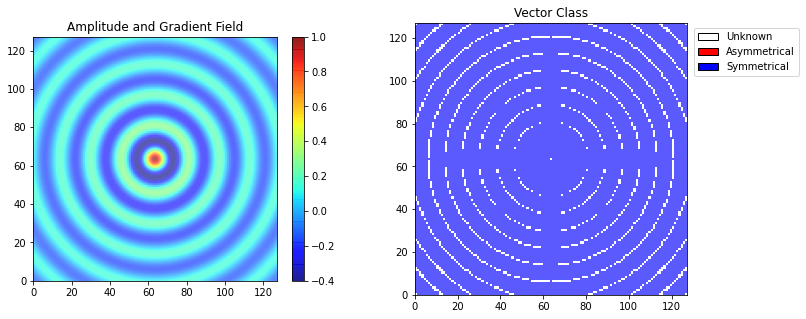

In [12]:
plotGPAVecClass(besselJ02D,ga)

# 4. Ruídos coloridos

In [25]:
white = cn.powerlaw_psd_gaussian(exponent=0.0, size=(127,127))
pink = cn.powerlaw_psd_gaussian(exponent=1.0, size=(127,127))
brown = cn.powerlaw_psd_gaussian(exponent=2.0, size=(127,127))
reddish = cn.powerlaw_psd_gaussian(exponent=5.0, size=(127,127))

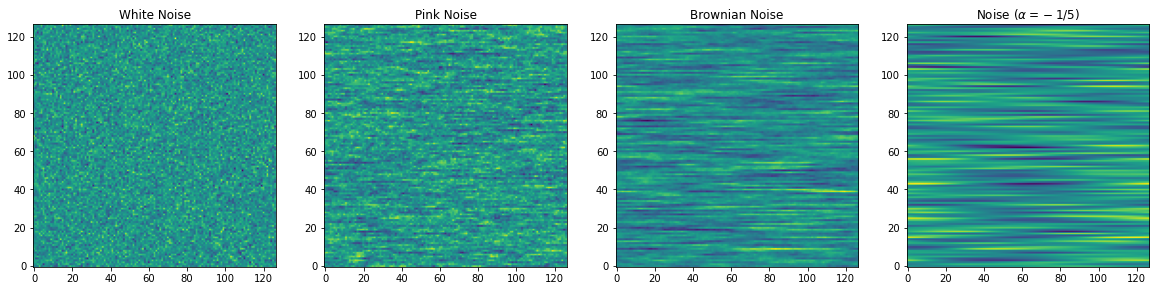

In [39]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(white,origin='lower')
plt.title("White Noise")

plt.subplot(1,4,2)
plt.imshow(pink,origin='lower')
plt.title("Pink Noise")

plt.subplot(1,4,3)
plt.imshow(brown,origin='lower')
plt.title("Brownian Noise")

plt.subplot(1,4,4)
plt.imshow(reddish,origin='lower')
plt.title(r"Noise ($\alpha = -1/5$)")

plt.show()

In [40]:
moments = ga.evaluate(white, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(white, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [1.942 0.034 0.514]
Momentos do campo gradiente simétrico: [1.998 1.977 1.476]


In [41]:
moments = ga.evaluate(pink, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(pink, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [1.942 0.05  0.514]
Momentos do campo gradiente simétrico: [1.998 1.975 1.471]


In [42]:
moments = ga.evaluate(brown, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(brown, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [1.917 0.018 0.458]
Momentos do campo gradiente simétrico: [1.998 1.965 1.493]


In [43]:
moments = ga.evaluate(reddish, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(reddish, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [1.915 0.008 0.424]
Momentos do campo gradiente simétrico: [1.998 1.958 1.491]


# 5. Ruído de Perlin
----

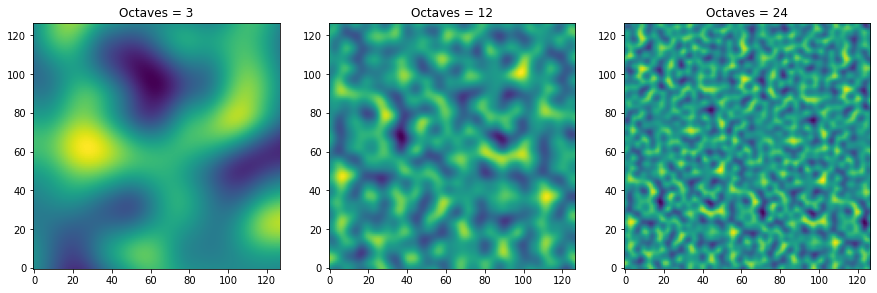

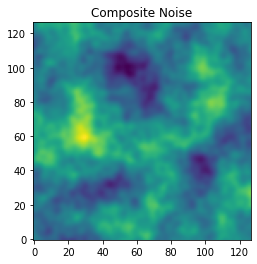

In [11]:
grid = np.linspace(0,1,127)

oct3x3 = PerlinNoise(octaves=3)
n3x3 = np.array([[oct3x3([x,y])  for x in grid] for y in grid])

oct6x6 = PerlinNoise(octaves=6)
n6x6 = np.array([[oct6x6([x,y])  for x in grid] for y in grid])

oct12x12 = PerlinNoise(octaves=12)
n12x12 = np.array([[oct12x12([x,y])  for x in grid] for y in grid])

oct18x18 = PerlinNoise(octaves=18)
n18x18 = np.array([[oct18x18([x,y])  for x in grid] for y in grid])

oct24x24 = PerlinNoise(octaves=24)
n24x24 = np.array([[oct24x24([x,y])  for x in grid] for y in grid])

decay = 5./3.
composite = n3x3/np.log(decay**3)+n6x6/np.log(decay**6)+n12x12/np.log(decay**12)+n18x18/np.log(decay**18)+n24x24/np.log(decay**24)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(n3x3,origin='lower')
plt.title("Octaves = 3")
plt.subplot(1,3,2)
plt.imshow(n12x12,origin='lower')
plt.title("Octaves = 12")
plt.subplot(1,3,3)
plt.imshow(n24x24,origin='lower')
plt.title("Octaves = 24")
plt.show()

plt.figure()
plt.imshow(composite,origin='lower')
plt.title("Composite Noise")
plt.show()

## 5.1. GPA e frequência espacial

O teste a seguir mostra o resultado do GPA para diferentes escalas de ruído, o objetivo é meramente ilustrativo.

In [22]:
moments = ga.evaluate(n3x3, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(n3x3, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [1.993 0.698 0.819]
Momentos do campo gradiente simétrico: [1.993 1.977 1.122]


In [23]:
moments = ga.evaluate(n12x12, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(n12x12, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [1.985 0.142 0.522]
Momentos do campo gradiente simétrico: [1.997 1.979 1.432]


In [24]:
moments = ga.evaluate(n24x24, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(n24x24, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [1.985 0.115 0.55 ]
Momentos do campo gradiente simétrico: [1.998 1.978 1.443]


Para um anaálise mais confiável, na célula a seguir é realizado uma amostragem do GPA com diferentes escalas. Neste teste os padrões são de 63x63.

Um resultado interessante é que a distribuição em cada escala não coincide necessariamente no quesito de simetria/assimetria.

In [16]:
def sampleGPAPerlin(octaves=[3,6,8,12,24],nSample=100,moment='G2',symmetrycalGrad=1):
    result = []
    grid = np.linspace(0,1,63)
    for s in octaves:
        octResult = []
        for x in tqdm.tqdm(range(nSample)):
            pn = PerlinNoise(octaves=s)
            m = np.array([[pn([x,y])  for x in grid] for y in grid])
            moments = ga.evaluate(m, moment=[moment],symmetrycalGrad=symmetrycalGrad)
            octResult.append(moments[0])
        result.append(octResult)
    return result

In [14]:
bx = sampleGPAPerlin(octaves=[3,6,8,12,24],nSample=100,moment='G2',symmetrycalGrad=1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


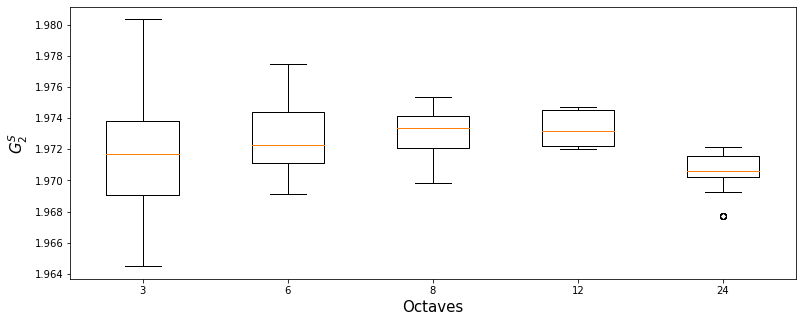

In [15]:
plt.figure(figsize=(13,5))
plt.boxplot(bx)
plt.xlabel("Octaves",fontsize=15)
plt.ylabel(r"$G^S_2$",fontsize=15)
xticks = ['3','6','8','12','24']
plt.xticks([1,2,3,4,5],xticks)
plt.show()

In [17]:
bx = sampleGPAPerlin(octaves=[3,6,8,12,24],nSample=100,moment='G2',symmetrycalGrad=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


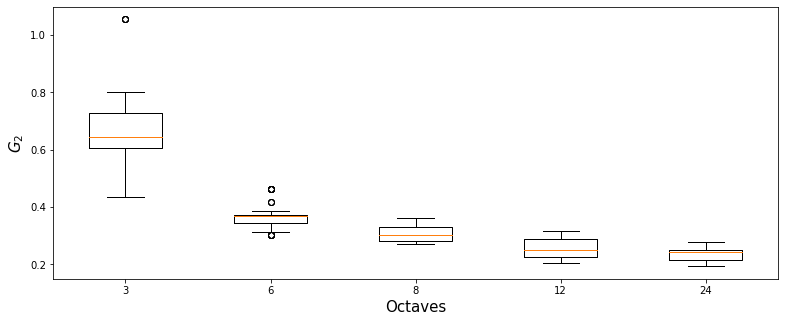

In [18]:
plt.figure(figsize=(13,5))
plt.boxplot(bx)
plt.xlabel("Octaves",fontsize=15)
plt.ylabel(r"$G_2$",fontsize=15)
xticks = ['3','6','8','12','24']
plt.xticks([1,2,3,4,5],xticks)
plt.show()

In [19]:
bx = sampleGPAPerlin(octaves=[3,6,8,12,24],nSample=100,moment='G3',symmetrycalGrad=1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


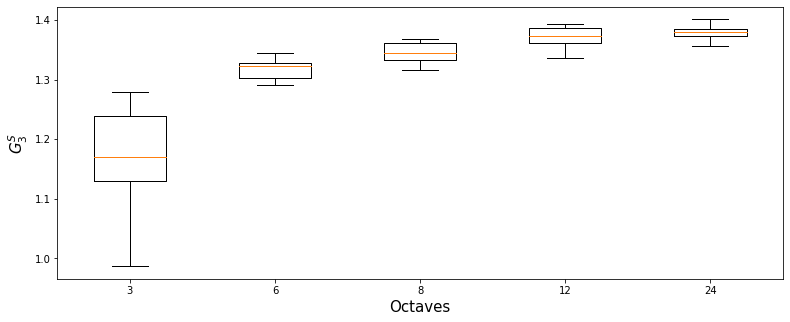

In [20]:
plt.figure(figsize=(13,5))
plt.boxplot(bx)
plt.xlabel("Octaves",fontsize=15)
plt.ylabel(r"$G^S_3$",fontsize=15)
xticks = ['3','6','8','12','24']
plt.xticks([1,2,3,4,5],xticks)
plt.show()

## 5.2. GPA e ruido composto

Para mimetizar o efeitos que são observados na geografia de um terreno e da dinâmica de fluidos, geralmente utiliza-se uma composição de ruídos em diversas escalas 

In [25]:
moments = ga.evaluate(composite, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(composite, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [1.986 0.182 0.572]
Momentos do campo gradiente simétrico: [1.998 1.975 1.4  ]
